## Evaluation Metric
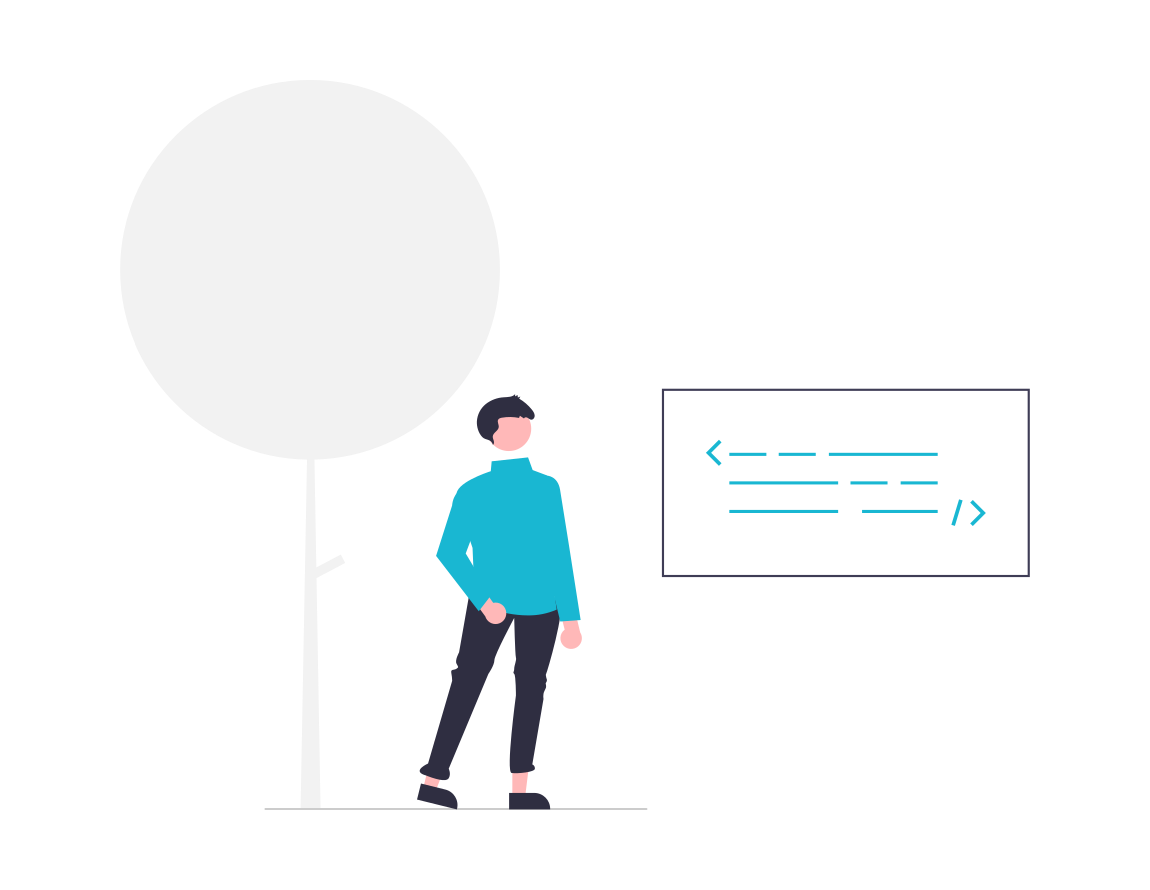

The [evaluation metric](https://www.kaggle.com/competitions/amex-default-prediction/overview/evaluation), 𝑀, for the [American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction) competition is the mean of two measures of rank ordering: Normalized Gini Coefficient, 𝐺, and default rate captured at 4%, 𝐷.

```𝑀 = 0.5 * (𝐺 + 𝐷)```

The default rate captured at 4% is the percentage of the positive labels (defaults) captured within the highest-ranked 4% of the predictions, and represents a Sensitivity/Recall statistic.

For both of the sub-metrics 𝐺 and 𝐷, the negative labels are given a weight of 20 to adjust for downsampling.

This notebook provides snippets of this custom metric using different implementations:

* [Pandas (Official)](#Pandas-Implementation-%28Official%29)
* [Datatable](#Datatable-Implementation)
* [JAX](#JAX-Implementation)
* [Numpy](#Numpy-Implementation)
* [PyTorch](#PyTorch-Implementation)
* [TensorFlow](#TensorFlow-Implementation)

## Pandas Implementation (Official)
The official Python code for implementing the metric using pandas dataframes can be found in [this notebook](https://www.kaggle.com/code/inversion/amex-competition-metric-python).

In [ ]:
# https://www.kaggle.com/code/inversion/amex-competition-metric-python
import pandas as pd

def amex_metric_official(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()

    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)


## Datatable Implementation
The metric can be implemented using [datatable](https://datatable.readthedocs.io) and runs about 6x faster than pandas as shared in [this post](https://www.kaggle.com/competitions/amex-default-prediction/discussion/327984).

In [ ]:
import datatable as dt

def amex_metric_datatable(y_true: dt.Frame, y_pred: dt.Frame) -> float:

    # create datatable frame
    df = dt.Frame(target=y_true, prediction=y_pred)

    # sort by descending prediction values
    df = df[:, :, dt.sort(-dt.f.prediction)]

    # create row weights, its percentage & cumulative sum
    df['weight'] = 20 - (dt.f.target * 19)
    df['weight_perc'] = dt.f.weight / df['weight'].sum1()
    df['weight_perc_cumsum'] = df['weight_perc'].to_numpy().cumsum() # use native datatable cumsum when v1.1.0 is released

    # filter the top 4%
    four_pct_filter = dt.f.weight_perc_cumsum <= 0.04

    # default rate captured at 4%
    d = df[four_pct_filter, 'target'].sum1() / df['target'].sum1()

    # weighted gini coefficient
    df['weighted_target'] = dt.f.target * dt.f.weight
    df['weighted_target_perc'] = dt.f.weighted_target / df['weighted_target'].sum1()
    df['lorentz'] = df['weighted_target_perc'].to_numpy().cumsum() # use native datatable cumsum when v1.1.0 is released
    df['gini'] = (dt.f.lorentz - dt.f.weight_perc_cumsum) * dt.f.weight
    gini = df['gini'].sum1()

    # max weighted gini coefficient
    total_pos = df['target'].sum1()
    total_neg = df.nrows - total_pos
    gini_max = 10 * total_neg * (total_pos + 20 * total_neg - 19) / (total_pos + 20 * total_neg)

    # normalized weighted gini coefficient
    g = gini / gini_max

    # amex metric
    m = 0.5 * (g + d)

    return m


## JAX Implementation
The metric can be implemented using a JIT-compiled [JAX](https://jax.readthedocs.io) function which is typically useful for JAX-based pipelines or models.

In [ ]:
import jax
import jax.numpy as jnp
from jax.config import config

config.update('jax_enable_x64', True)

@jax.jit
def amex_metric_jax(y_true: jnp.array, y_pred: jnp.array) -> float:

    # convert dtypes to float64
    y_true = jnp.array(y_true, dtype=jnp.float64)
    y_pred = jnp.array(y_pred, dtype=jnp.float64)

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = jnp.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = jnp.where(four_pct_filter, target, 0).sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)


## Numpy Implementation
The metric can be implemented using [numpy](https://numpy.org) as described in [this post](https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020) by [Pims](https://www.kaggle.com/yunchonggan) (almost 20x faster than pandas, hence used this version here) or in [this post](https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534) by [kyakovlev](https://www.kaggle.com/kyakovlev).


In [ ]:
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
import numpy as np

def amex_metric_numpy(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)


## PyTorch Implementation
The metric can be implemented using [PyTorch](https://pytorch.org) which is typically useful for PT-based pipelines or models.

In [ ]:
import torch

def amex_metric_pytorch(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:

    # convert dtypes to float64
    y_true = y_true.double()
    y_pred = y_pred.double()

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_pred.shape[0] - n_pos

    # sorting by descring prediction values
    indices = torch.argsort(y_pred, dim=0, descending=True)
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum(dim=0)
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum(dim=0)
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)


## TensorFlow Implementation
The metric can be implemented using [TensorFlow](https://www.tensorflow.org) which is typically useful for TF-based pipelines or models.

In [ ]:
import tensorflow as tf

def amex_metric_tensorflow(y_true: tf.Tensor, y_pred: tf.Tensor) -> float:

    # convert dtypes to float64
    y_true = tf.cast(y_true, dtype=tf.float64)
    y_pred = tf.cast(y_pred, dtype=tf.float64)

    # count of positives and negatives
    n_pos = tf.math.reduce_sum(y_true)
    n_neg = tf.cast(tf.shape(y_true)[0], dtype=tf.float64) - n_pos

    # sorting by descring prediction values
    indices = tf.argsort(y_pred, axis=0, direction='DESCENDING')
    preds, target = tf.gather(y_pred, indices), tf.gather(y_true, indices)

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = tf.cumsum(weight / tf.reduce_sum(weight))
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = tf.reduce_sum(target[four_pct_filter]) / n_pos

    # weighted gini coefficient
    lorentz = tf.cumsum(target / n_pos)
    gini = tf.reduce_sum((lorentz - cum_norm_weight) * weight)

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)


## Cross Verification
Cross verifying if the metric calculation using the different implementation yields the (almost) same results. In some cases there might be minor differences due to different sorting mechanisms of equal values.

In [ ]:
## load data
import pandas as pd

train_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv', index_col='customer_ID')
train_labels

In [ ]:
## generate random predictions
import random

predictions = pd.DataFrame({'prediction': (train_labels['target'] / 2 + [random.random() for i in range(train_labels.shape[0])])/2})
predictions

In [ ]:
print('Metric Evaluation Values\n')
print(f'Pandas (Official): {amex_metric_official(train_labels, predictions)}')
print(f'Datatable:         {amex_metric_datatable(dt.Frame(train_labels), dt.Frame(predictions))}')
print(f'JAX:               {amex_metric_jax(jnp.array(train_labels).ravel(), jnp.array(predictions).ravel())}')
print(f'Numpy:             {amex_metric_numpy(train_labels.to_numpy().ravel(), predictions.to_numpy().ravel())}')
print(f'PyTorch:           {amex_metric_pytorch(torch.tensor(train_labels.values).ravel(), torch.tensor(predictions.values).ravel())}')
print(f'TensorFlow:        {amex_metric_tensorflow(tf.convert_to_tensor(train_labels), tf.convert_to_tensor(predictions))}')


## Speed Comparison
Comparing the processing time of metric calculation using the different implementations. Each implementation is run 10 times and its average is taken.

In [ ]:
import time

time_official = []
time_datatable = []
time_jax = []
time_numpy = []
time_pytorch = []
time_tensorflow = []

for i in range(10):
    start_official = time.time()
    metric_official = amex_metric_official(train_labels, predictions)
    end_official = time.time()
    time_official.append((end_official-start_official))

    start_datatable = time.time()
    metric_datatable = amex_metric_datatable(dt.Frame(train_labels), dt.Frame(predictions))
    end_datatable = time.time()
    time_datatable.append((end_datatable-start_datatable))

    start_jax = time.time()
    metric_jax = amex_metric_jax(jnp.array(train_labels).ravel(), jnp.array(predictions).ravel())
    end_jax = time.time()
    time_jax.append((end_jax-start_jax))

    start_numpy = time.time()
    metric_numpy = amex_metric_numpy(train_labels.to_numpy().ravel(), predictions.to_numpy().ravel())
    end_numpy = time.time()
    time_numpy.append((end_numpy-start_numpy))

    start_pytorch = time.time()
    metric_pytorch = amex_metric_pytorch(torch.tensor(train_labels.values).ravel(), torch.tensor(predictions.values).ravel())
    end_pytorch = time.time()
    time_pytorch.append((end_pytorch-start_pytorch))

    start_tensorflow = time.time()
    metric_tensorflow = amex_metric_tensorflow(tf.convert_to_tensor(train_labels), tf.convert_to_tensor(predictions))
    end_tensorflow = time.time()
    time_tensorflow.append((end_tensorflow-start_tensorflow))

print(f'Metric Processing Time (in seconds)\n')
print(f'Numpy:             {sum(time_numpy) / len(time_numpy)}')
print(f'PyTorch:           {sum(time_pytorch) / len(time_pytorch)}')
print(f'TensorFlow:        {sum(time_tensorflow) / len(time_tensorflow)}')
print(f'Datatable:         {sum(time_datatable) / len(time_datatable)}')
print(f'JAX:               {sum(time_jax) / len(time_jax)}')
print(f'Pandas (Official): {sum(time_official) / len(time_official)}')


## Different / Better / Faster
Have a different or better or faster implementation of the metric?

Please share it in the comments and I'll be happy to update the notebook with more implementations as a growing compilation.